In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

# The landscape is a 2D quadratic function, the longer axis is A times longer than the shorter axis.
# theta is the angle of the major axis
# the initial point is (1,1) in the coordinates where the longer axis is x, the shorter axis is y

# Adam is *not* equivariant to SO(2) rotation.

theta = np.pi/4
A = 20
a0 = 1.0
b0 = 1.0
a = a0*np.cos(theta)+b0*np.sin(theta)
b = -a0*np.sin(theta)+b0*np.cos(theta)


class T(nn.Module):
    def __init__(self, a=a, b=b):
        super(T, self).__init__()
        self.a = torch.nn.Parameter(torch.tensor(a, dtype=torch.float, requires_grad=True))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float, requires_grad=True))
    
    def forward(self, x):
        return torch.stack([self.a, self.b])
    

def L(x):
    a = x[0]
    b = x[1]
    x1 = a*np.cos(theta) + b*np.sin(theta)
    x2 = -a*np.sin(theta) + b*np.cos(theta)
    return x1**2 + A*x2**2

In [2]:
t = T()
epochs = 2000
log = 1000
switch_epoch = 10**10
lr = 1e-2

optimizer = optim.Adam(t.parameters(), lr=lr, eps=1e-8, betas=(0,0.999))

losses = []
parameters = []

for epoch in range(epochs):

    if (epoch+1) % switch_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr

    t.train()
    optimizer.zero_grad()
    loss = L([t.a,t.b])
    #loss_log = torch.log(loss)
    losses.append(loss.detach().numpy())
    parameters.append([t.a.clone().detach().numpy(), t.b.clone().detach().numpy()])
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch%log == 0:
        print('Epoch:  %d | loss: %.12f ' %(epoch, loss))

Epoch:  0 | loss: 20.999998092651 
Epoch:  1000 | loss: 0.002061293228 


Text(0.5, 1.0, '$\\theta=\\pi/4$')

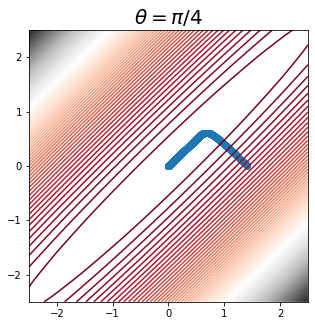

In [3]:
plt.figure(figsize=(5,5))
lim = 2.5

x = np.linspace(-lim, lim, 50)
y = np.linspace(-lim, lim, 50)

def f(X, Y):
    A = 100
    x1 = X*np.cos(theta) + Y*np.sin(theta)
    x2 = -X*np.sin(theta) + Y*np.cos(theta)
    return x1**2 + A*x2**2

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
plt.contour(X, Y, Z, 100, cmap='RdGy')

parameters = np.array(parameters)
plt.scatter(parameters[:,0],parameters[:,1])
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
#plt.title(r'$\theta$='+"{}".format(theta),fontsize=20)
plt.title(r'$\theta=\pi/4$',fontsize=20)

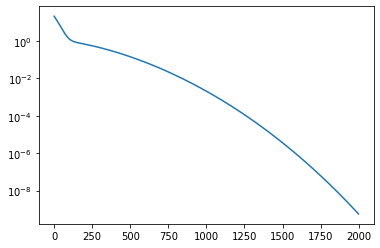

In [4]:
plt.plot(np.arange(epochs), losses)
plt.yscale('log')